In [21]:
import numpy as np
import skimage.segmentation
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import feature
import warnings
import skimage.segmentation

np.set_printoptions(precision=3,suppress=True)


def scale_image(img_path,max_size):
    warnings.filterwarnings('ignore')
    image = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    size = image[:,:,0].size
    # if  size > max_size:
    #     scale = np.sqrt(max_size/float(size))
    #     rescaled = skimage.transform.rescale(image,scale,mode='reflect',preserve_rane=True)
    #     rescaled = rescaled.astype(np.ubyte)
    #     return padding(rescaled)
    return padding(image)


def calculate_glcm(gray,dist=5,ang=0):
    gray = cv2.cvtColor(gray,cv2.COLOR_RGB2GRAY)
    glcm = feature.greycomatrix(gray,[dist],[ang],symmetric=True,normed=True)
    energy = feature.greycoprops(glcm,prop="energy")
    return energy[0][0]

def padding(array,required=(8,8)):
	current = np.asarray(array.shape[0:2])
	required = np.asarray(required)
	over = np.mod(current,required)
	add = np.mod(required-over,required)
	width = ((0,add[0]),(0,add[1]),(0,0))
	return skimage.util.crop(array,tuple(width),'edge')

def color_coded_block(img,index,depth,value,col):
	h,w = index
	row,column = skimage.draw.polygon(np.array([h,h,h+depth,h+depth]),np.array([w,w+depth,w+depth,w]))
	skimage.draw.set_color(img,(row,column),col,alpha=value)
	return img

def get_blocks(img,depth):
    blocks = []; index = []
    for h in range(0,img.shape[0],depth):
        for w in range(0,img.shape[1],depth):
            if len(img.shape)== 2:
                block = img[h:h+depth,w:w+depth]
            else:
                block = img[h:h+depth,w:w+depth,:]
            blocks.append(block)
            index.append((h,w))
    return blocks,index

def color_coded_blocks(img,index,depth,value):
	out_image = np.copy(img)
	col = np.array([128,255,0])
	for i in range(len(index)):
		out_image = color_coded_block(out_image,index[i],depth,value[i],col)
	return out_image


def red_blocks(image,mask,depth,block_threshold):
    red_blocks = []; red_index = []
    blocks,inds = get_blocks(image,depth)
    for i in range(len(blocks)):
        x,y = inds[i]
        bmask = mask[x:x+depth,y:y+depth,:]
        prop = np.sum(bmask[:,:,0]) / depth**2
        if prop > block_threshold and bmask.shape[:2] == (depth,depth):
            red_blocks.append(blocks[i])
            red_index.append(inds[i])
    return red_blocks,red_index

def mask_image(img,mask):    
	masked = np.copy(img)
	if img.ndim == 3 and mask.ndim == 2:
		mask = np.stack([mask,mask,mask],axis=-1).astype(bool)
	elif img.ndim == 2 and mask.ndim == 3:
		mask = mask[:,:,0]
	masked[np.logical_not(mask)] = 0
	return masked


# labels segmented regions of image
def label(mask):
	return skimage.measure.label(mask.astype(int),connectivity=1,return_num=True)

def red_mask(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_range = np.array([2,75,100])
    upper_range = np.array([20,250,250])
    return cv2.inRange(hsv,lower_range,upper_range)


def non_red(img):
    flag = True
    minimum_pixel = 64
    radius =4
    masked = red_mask(img)
    if flag: 
        masked = morphology.remove_small_objects(label(masked)[0],min_size=minimum_pixel)
        masked = morphology.remove_small_holes(label(masked)[0],area_threshold=minimum_pixel)
        selem  = morphology.disk(radius)
        masked = morphology.binary_closing(masked,selem = selem)
    return np.stack([masked,masked,masked],axis=-1).astype(bool)


def energy_gLCM(image,depth,thresh_hold,distance,thresh):
    red_block , red_index = red_blocks(image,non_red(image),depth,thresh_hold)
    energy = []
    keep_blocks = []
    keep_index = []
    for i in range(len(red_block)):
        if red_block[i].shape[0] == red_block[i].shape[1]:
            energy_out = calculate_glcm(red_block[i],dist=distance)
            if energy_out < thresh:
                energy.append(energy_out)
                keep_blocks.append(red_block[i])
                keep_index.append(red_index[i])
    masked = mask_image(image,non_red(image))
    energy = np.asarray(energy)
#     print("energy",energy)
    if energy.size > 0:
        drawn = color_coded_blocks(masked,keep_index,depth,0.5*energy / np.amax(energy))
#         print("drawn",type(drawn))
    else:
        drawn = masked
#         print("drawn",type(drawn))
   
    fig = plt.figure()
    ay1 = fig.add_axes([0.3,0.3,0.5,50])
    ay2 = fig.add_axes([0.1,-1,0.5,50])
    # cv2.imshow("",image)
    fig.tight_layout()
    ay1.imshow(image)
    ay2.imshow(drawn)
    # print(ay1)
    # print(ay2)
    
    # fig.show()
    # return ay1 , ay2 , fig, drawn
    return



# depth = 15
# thresh_hold = 0.8
# distance = 5
# thresh = 0.07
# image_path = "C:\\Users\\Admin\\Desktop\\Projects\\corossion\\rust.5.jpg"
# img = scale_image(image_path, max_size=1000000)

# energy_gLCM(img,depth,thresh_hold,distance,thresh)



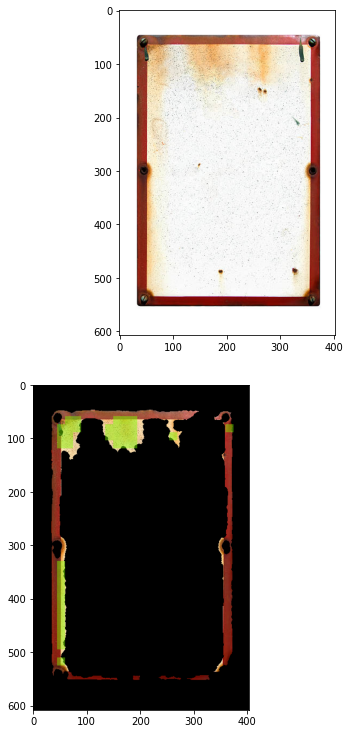

In [22]:
import tkinter as tk
from PIL import ImageTk, Image
from tkinter import filedialog
import keras
from keras.preprocessing import image



def load_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    basewidth = 150 # Processing image for dysplaying
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1])).pack()
    panel_image = tk.Label(frame, image=img).pack()
    

def classify():
    original = Image.open(image_data)
    original = original.resize((150, 150), Image.ANTIALIAS)
    model = keras.models.load_model('model\\model.h5')
    image_test = image.img_to_array(original)
    image_test = image_test.reshape((1,) + image_test.shape)
    image_test =image_test.astype('float32') / 255
    rust_prob = model.predict(image_test)
    #print(rust_prob)
    if (rust_prob > 0.50):
        pred = "This is a Rust image"
        depth = 15
        thresh_hold = 0.8
        distance = 5
        thresh = 0.07
        im = scale_image(image_data,max_size=1000000)
        energy_gLCM(im,depth,thresh_hold,distance,thresh)
      
        # im = scale_image(image_data,max_size=1000000)
        # ay1 , ay2 , fig, drawn  =  energy_gLCM(im,depth,thresh_hold,distance,thresh)
        # ay1.imshow(im)
        # ay2.imshow(drawn)
        # print(ay1)
        # print(ay2)
    
        # fig.show()
       
    else:
        pred = "This is a no Rust image"
    label = pred
    table = tk.Label(frame, text="Result:").pack()
    result = tk.Label(frame,text= str(label).upper()).pack()
         
root = tk.Tk()
root.title('Corossion Detector')
#root.iconbitmap('class.ico')
root.resizable(False, False)

tit = tk.Label(root, text="Choose an image and press Classify Image", padx=25, pady=6, font=("", 12)).pack()

canvas = tk.Canvas(root, height=800, width=1000, bg='#000080')
canvas.pack()

frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.6, relheight=0.5, relx=0.2, rely=0.25)

chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="white", bg="grey", command=load_img)
chose_image.pack(side=tk.LEFT)

class_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="white", bg="grey", command=classify)
class_image.pack(side=tk.RIGHT)


root.mainloop()

In [18]:
#pip install scikit-image --upgrade --user